Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2023

Name: FILL IN YOUR NAMES HERE

# Neural Data Science Project 01

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

## Context
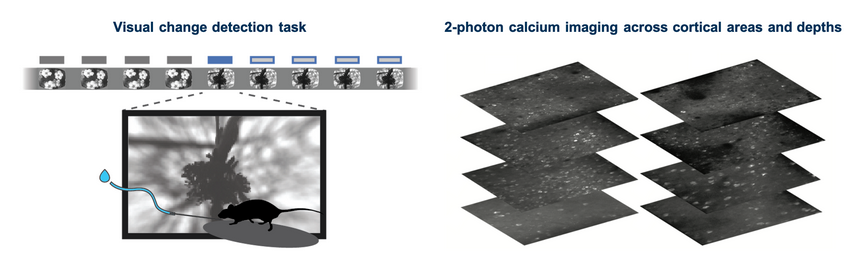

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

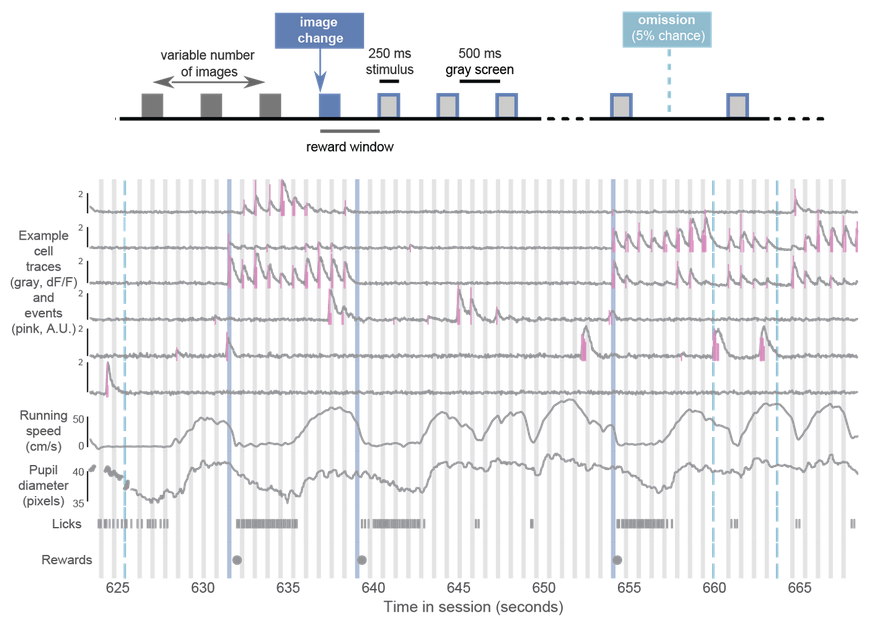

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the ROI masks for each cell
- a maximum activity projection of all ROIs
- running speed
- table of stimulus epochs

You will only work with a drifting grating stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

### Question session #1
- Dataset paper link? 
- Maximum activity projection?
- Plot actual stimuli? Where can I find them?
- ROI?
- Features in stimulus metadata?
- What do licks mean? What does mouse get reward for? PAPER PAPER PAPER PAPER

https://portal.brain-map.org/explore/circuits/visual-behavior-2p

### Question session #2
- What is spatial structure? Is it in the brain? Or in spatial location of a visual stimulus?

## Imports

In [1]:
# import packages here

import numpy as np
import pandas as pd
from scipy import signal, stats

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
data_path = Path("../data/")

In [3]:
# load data
def load_data(path="."):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(data_path / "dff_data_dsi.npz", allow_pickle=True)
    data = dict(data)
    array2df(
        data,
        "stim_table",
        ["temporal_frequency", "orientation", "blank_sweep", "start", "end"],
    )
    array2df(data, "stim_epoch_table", ["start", "end", "stimulus"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data()

print("Overview of the data")
print_info(data)

Overview of the data
[t] - <class 'numpy.ndarray'>, - (115471,)
[dff] - <class 'numpy.ndarray'>, - (106, 115471)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (628, 5)
[roi_masks] - <class 'numpy.ndarray'>, - (106, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 115471)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



## Data exploration

### Setting working variables

In [20]:
times = data['t']
dff = data['dff']
stim = data['stim_table']
roi = data['roi_masks']
max_projection = data['max_projection']
times[-1]

3849.61999

### Stimuli

In [4]:
data['stim_table']

,temporal_frequency,orientation,blank_sweep,start,end
0,1.0,225.0,0.0,747.0,807.0
1,2.0,180.0,0.0,837.0,897.0
2,4.0,90.0,0.0,927.0,987.0
3,1.0,270.0,0.0,1018.0,1077.0
4,4.0,135.0,0.0,1108.0,1168.0
...,...,...,...,...,...
623,4.0,315.0,0.0,114794.0,114854.0
624,2.0,45.0,0.0,114884.0,114944.0
625,4.0,180.0,0.0,114975.0,115034.0
626,4.0,270.0,0.0,115065.0,115125.0


In [16]:
data['stim_epoch_table']

,start,end,stimulus
0,drifting_gratings,747,18775
1,natural_movie_three,19709,37767
2,natural_movie_one,38671,47699
3,drifting_gratings,48602,66630
4,spontaneous,66780,75697
5,natural_movie_three,75698,93756
6,drifting_gratings,94659,115215


In [5]:
data

{'t': array([   9.67741,    9.71067,    9.74392, ..., 3849.55347, 3849.58673,
        3849.61999]),
 'dff': array([[0.08007366, 0.07333259, 0.10623901, ..., 0.12913607, 0.11774017,
         0.37138304],
        [0.3027197 , 0.19215527, 0.24838713, ..., 0.23082796, 0.0993453 ,
         0.3469142 ],
        [0.1681573 , 0.24385664, 0.11232736, ..., 0.11168884, 0.29000354,
         0.23824105],
        ...,
        [0.19818163, 0.1592283 , 0.21727051, ..., 0.20087314, 0.33797556,
         0.4996581 ],
        [0.23925741, 0.11036097, 0.16150714, ..., 0.13805537, 0.19728656,
         0.23281547],
        [0.14366886, 0.08441056, 0.03815553, ..., 0.09202033, 0.1976442 ,
         0.23586313]], dtype=float32),
 'stim_table':      temporal_frequency  orientation  blank_sweep     start       end
 0                   1.0        225.0          0.0     747.0     807.0
 1                   2.0        180.0          0.0     837.0     897.0
 2                   4.0         90.0          0.0     927.0

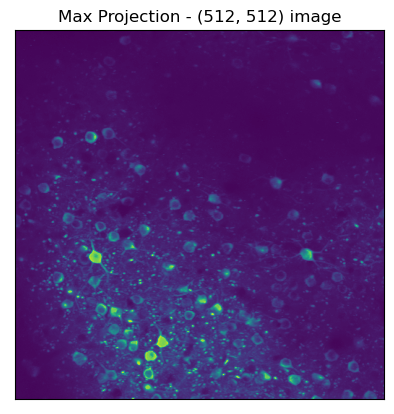

In [14]:
plt.imshow(data['max_projection'])
plt.title("Max Projection - (512, 512) image");
plt.xticks([]); plt.yticks([]);

## Question

**Is there spatial structure in the preferred orientation/direction/spatial frequency?**

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing 
2. Spike inference 
3. Tuning function fitting 
4. Statistical testing. 

It is sufficient to assess spatial structure visually. Bonus points for proper statistical assessment. Also bonus points if you focus on specific cell types.